<a href="https://colab.research.google.com/github/girijeshcse/chatbot_savy/blob/main/notebooks/Final_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Summary of problem statement, data and findings**

## **Abstract**

Industrial accidents have been critical for the past several decades. It is an urgent need for industries/companies around the globe to understand why employees still suffer some injuries/accidents in plants. But after analysing the data there is a potential gap in accessing the safety risk measures.

By analysing the provided dataset, we aim to:


1.   Bridge the existing gap in the risk assessment 
2.   Find the hidden patterns in the dataset to get insights into accidental incidents 
3. Predict the real-time accident severity, given the accident description. So that appropriate measure can be taken



## **Data**

This The database is basically records of accidents from 12 different plants in 03 different countries which every line in the data is an
occurrence of an accident.

**Columns description:**
1.   **Data:** timestamp or time/date information
2.   **Countries:** which country the accident occurred (anonymised)
3.   **Local:** the city where the manufacturing plant is located (anonymised)
4. **Industry sector:** which sector the plant belongs to
5. **Accident level:** from I to VI, it registers how severe was the accident (I means not severe but VI means very severe)
6. **Potential Accident Level:** Depending on the Accident Level, the database also registers how severe the accident could have been (due to other factors
involved in the accident)
7. **Gender:** if the person is male of female
8. **Employee or Third Party:** if the injured person is an employee or a third party
9. **Critical Risk:** some description of the risk involved in the accident
10. **Description:** Detailed description of how the accident happened.

**Link to download the dataset:** https://drive.google.com/file/d/1_GmrRP1S2OIa02KlfOBNkYa8uxazGbfE/view?usp=sharing

**Original dataset link:** https://www.kaggle.com/ihmstefanini/industrial-safety-and-health-analytics-database


## **Findings**


*  There is an extra column **Unnamed: 0** which is not needed
*   There are a total of **425** records and there is huge imbalance in target distribution:
 -  Without handling target imbalance model performance would be **very poor**
  -  Though there is target imbalance the quality of the data is **good**
  -  **No null** values in the dataset
  
* Some of the columns **Data**, and **Genre** are not properly named. But they are close enough to understand what they mean!



In [1]:
import pandas as pd
import numpy as np
from google.colab import drive

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer
import re, string

from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Dropout,LSTM,Embedding, Bidirectional, Flatten, Activation, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import Input, Model

from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

from sklearn.utils import resample
import pickle
import os

In [2]:
drive.mount('/content/gdrive/')
parent_dir = '/content/gdrive/MyDrive/Colab Notebooks/Capstone/'

Mounted at /content/gdrive/


In [3]:
seed = 7

In [4]:
data = pd.read_csv(parent_dir+'Data Set - industrial_safety_and_health_database_with_accidents_description.csv')

In [5]:
data.head(10)

,Unnamed: 0,Data,Countries,Local,Industry Sector,Accident Level,Potential Accident Level,Genre,Employee or Third Party,Critical Risk,Description
0,0,2016-01-01 00:00:00,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...
1,1,2016-01-02 00:00:00,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...
2,2,2016-01-06 00:00:00,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...
3,3,2016-01-08 00:00:00,Country_01,Local_04,Mining,I,I,Male,Third Party,Others,Being 9:45 am. approximately in the Nv. 1880 C...
4,4,2016-01-10 00:00:00,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Others,Approximately at 11:45 a.m. in circumstances t...
5,5,2016-01-12 00:00:00,Country_02,Local_05,Metals,I,III,Male,Third Party (Remote),Pressurized Systems,During the unloading operation of the ustulado...
6,6,2016-01-16 00:00:00,Country_02,Local_05,Metals,I,III,Male,Employee,Fall prevention (same level),The collaborator reports that he was on street...
7,7,2016-01-17 00:00:00,Country_01,Local_04,Mining,I,III,Male,Third Party,Pressed,"At approximately 04:50 p.m., when the mechanic..."
8,8,2016-01-19 00:00:00,Country_02,Local_02,Mining,I,IV,Male,Third Party (Remote),Others,Employee was sitting in the resting area at le...
9,9,2016-01-26 00:00:00,Country_01,Local_06,Metals,I,II,Male,Third Party,Chemical substances,At the moment the forklift operator went to ma...


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Unnamed: 0                425 non-null    int64 
 1   Data                      425 non-null    object
 2   Countries                 425 non-null    object
 3   Local                     425 non-null    object
 4   Industry Sector           425 non-null    object
 5   Accident Level            425 non-null    object
 6   Potential Accident Level  425 non-null    object
 7   Genre                     425 non-null    object
 8   Employee or Third Party   425 non-null    object
 9   Critical Risk             425 non-null    object
 10  Description               425 non-null    object
dtypes: int64(1), object(10)
memory usage: 36.6+ KB


From the above info, we can see that there are no null values in the data set.

- From the above data, we can see that the first column **Unnamed: 0** is merely an index, which we don't need and we can drop it.

- **Data** column is actually the **Date**, which is not needed for building our **NLP model** but we can see if we need this for any **EDA**, later we can drop it.

- **Countries** column can be used for doing some **EDA** to see how many accidents happen in a particular country and if some countries have more safety risk compared to others.

- **Local** column can also be used for some **EDA** to identify which cities are more accident prone, will drop it later before model training.

- **Industry Sector** can also be used for **EDA** to identify industries which have more safety risks.

- **Accident Level** is our target column which we need to be able to predict based on accident description.

- **Potential Accident Level** just indicates what could have been the severity of the accident.

- **Genre** is basically **Gender**, we will use this column also for **EDA** to see distribution among male/female but won't be needed to train our model.

- **Employee or Third Party** column can also be used for some **EDA** but not needed for model training.

- **Critical Risk** basically identifies the area/component where accident has happened.

- **Description** basically is the textual information about the accident which we will be using to predict the accident level. We will cleanse and convert this text into vectors which will then be passed to our models for training/testing.

## **EDA Approach**

We will look at the distribution of data for each column and how they are related, and gain some insights by data **visualizations** and **analysis**. And find some hidden pattern out of it



In [7]:
data.groupby(by=['Countries', 'Local']).count().sort_values(['Countries', 'Description'],ascending=False)

Unnamed: 0  Data  ...  Critical Risk  Description
Countries  Local                       ...                            
Country_03 Local_10          44    44  ...             44           44
Country_02 Local_05          59    59  ...             59           59
           Local_08          27    27  ...             27           27
           Local_02          24    24  ...             24           24
           Local_07          14    14  ...             14           14
           Local_12           4     4  ...              4            4
           Local_09           2     2  ...              2            2
Country_01 Local_03          90    90  ...             90           90
           Local_01          57    57  ...             57           57
           Local_04          56    56  ...             56           56
           Local_06          46    46  ...             46           46
           Local_11           2     2  ...              2            2

[12 rows x 9 columns]

1. From the above distribution we can see that the most number of accidents have happened in **Local_03** from **Country_01** followed by **Local_05** from **Country_02**.

2. If we look closely into the above data, **Country_01** has more accidents across different cities compared to other two countries.

3. With this observation, I think we can say that **Country_01** is less safe compared to others.

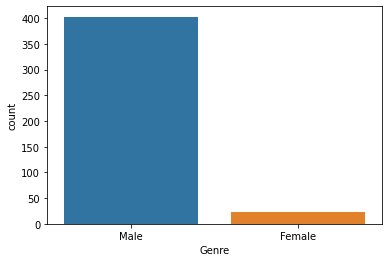

In [8]:
# Lets check the distribution of the accidents among male and female.
sns.countplot(x=data['Genre']);

We can see that there's a huge **skew** between the accidents among **male** and **female** employees, which is synonymus to real life scenarios in the **Industrial sectors**.

In [9]:
# Adds two new columns for Year wise and month wise distribution.
data['Month_Year'] = data['Data'].apply(lambda x: x[:7])
data['Year'] = data['Data'].apply(lambda x: x[:4])

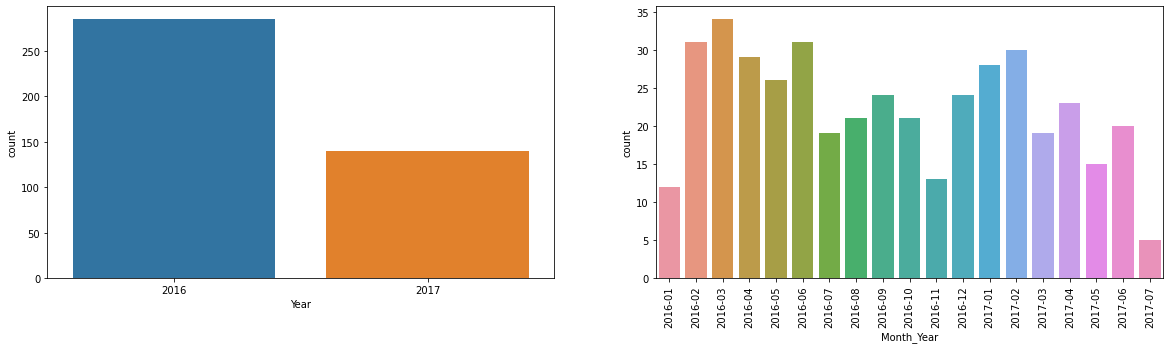

In [10]:
plt.rcParams["figure.figsize"] = (20,5)
fig, ax = plt.subplots(1,2)
plt.xticks(rotation=90)
sns.countplot(x=data['Year'], ax=ax[0]);
sns.countplot(x=data['Month_Year'], ax=ax[1]);
fig.show()

* From the above two distributions, we can see that number of accidents in **2016** were much more compared to **2017**.

* Also, if we see from the monthly distribution, the number of accidents are more in the month of **February** to **June** in **2016**. After some research we found that in **Brazil** more accidents happen in certain seasons. For this to be analysed we need more information about the **domain** & **geography** which is **not-provided** in **dataset** 

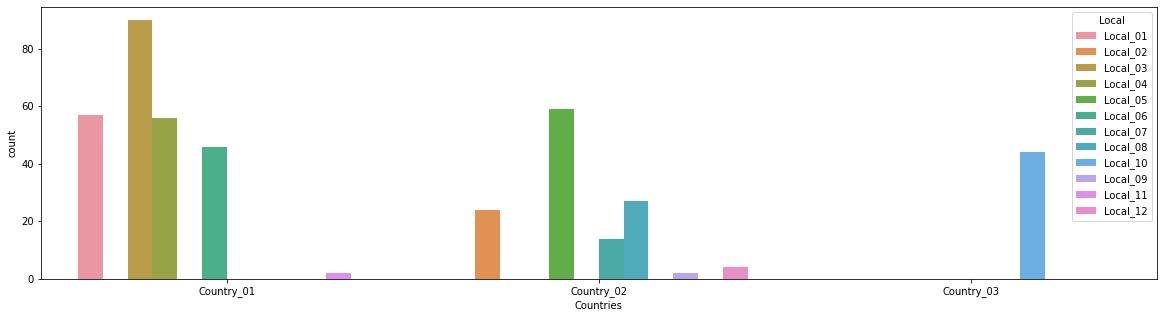

In [11]:
sns.countplot(x=data['Countries'], hue=data['Local']);

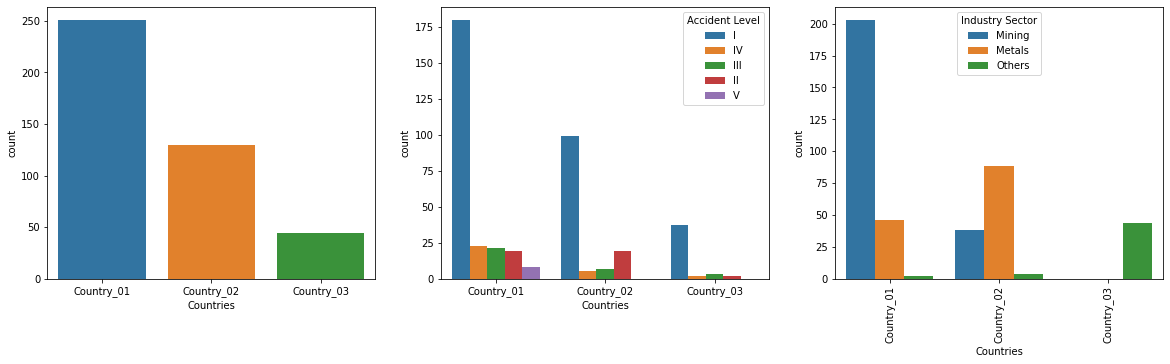

In [12]:
fig, ax = plt.subplots(1,3)
plt.xticks(rotation=90)
sns.countplot(x=data['Countries'], ax=ax[0]);
sns.countplot(x=data['Countries'], hue=data['Accident Level'], ax=ax[1]);
sns.countplot(x=data['Countries'], hue=data['Industry Sector'], ax=ax[2]);
fig.show()

* If we look at above distributions, **Country_01** has had most number of accidents and also the number of severe accidents are much more than other countries.

* **Country_01** is the only country which has had accidents with **Level V** severity.

* Coming to **Industry sector**, **Country_01** has had most accidents in **Mining** whereas **Country_02** has had most accidents in **Metals sector**.

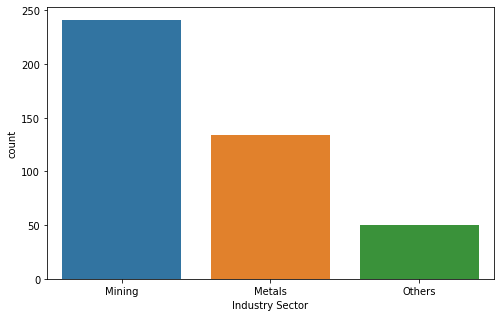

In [13]:
# Checking the accident distribution in the industries
plt.rcParams["figure.figsize"] = (8,5)
sns.countplot(x=data['Industry Sector']);

As we can see that the highest number of accidents are happening in **Mining industries** which has been the case, in general.

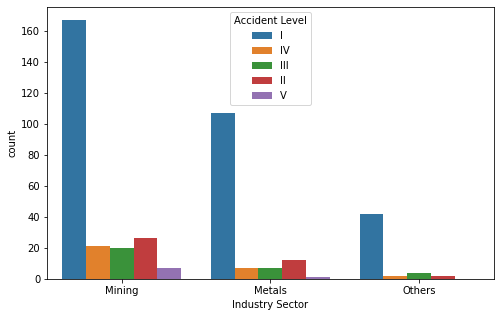

In [14]:
#Checking how critical the accidents have been in each industry
sns.countplot(x=data['Industry Sector'], hue= data['Accident Level']);

From the above chart we can see that most of the accidents have not been severe in all the sectors. As we don't see any **Level VI** accidents it means that there has not been a single accident which was most severe. Let's check the counts as well to verify that.

In [15]:
data['Accident Level'].value_counts()

I      316
II      40
III     31
IV      30
V        8
Name: Accident Level, dtype: int64

The problem description says that accident level could be between **I to VI**, but as we can see that there is not a single accident with value **VI**.

Apart from that we can also see that there is a huge **imbalance** in the **accident level distribution**.

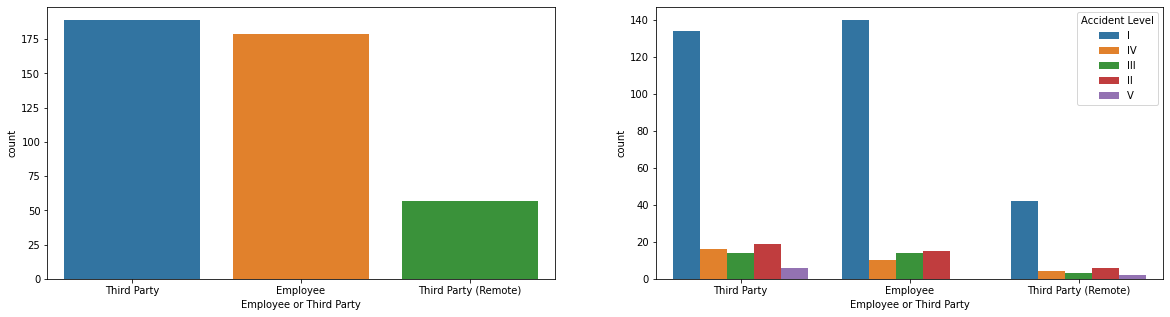

In [16]:
plt.rcParams["figure.figsize"] = (20,5)
fig, ax = plt.subplots(1,2)
sns.countplot(x=data['Employee or Third Party'], ax=ax[0]);
sns.countplot(x=data['Employee or Third Party'], hue=data['Accident Level'], ax=ax[1]);
fig.show()

1. From the above visualization, it is clear that the number of accidents are much more in **third party employees** compared to **own employees** which indicates that **third party** is more **prone** to **accidents**.

2. Also, the accident type distribution among **own employees** and **third party employees** is **same** as the overall accident distribution.

3. **IMP:** One of the key insight is that the **Level V accidents** are seen only in **Third party employees**

## **EDA Summary**

Based on the above **EDA**, we can make following observations:

1. Overall, there has **not** been a **single case** of most **severe accident level (VI)** which indicates that the **industries** have taken **appropriate measures** to **avoid** the **most severe accidents**.

2. The accident level distribution is **very skewed** where the least severe accidents are much more compared to more severe accidents which is also a good indication that industries have **taken measures** to prevent **severe accidents**, in general or we can say that the people have also taken right precautions to avoid severe accidents, in general.

3. The distribution in **male employees** is much more compared to **female employees**, which is also expected given the nature of employment.

4. There are **more accidents** in **third party employees** compared to **own employees** which can indicate two things, either the third party does not take enough precautions or **the industry** does not provide **enough safety measures** for **third party employees**.

5. The most number of accidents are from **Country_01** which indicates that it is **most prone** to accidents and also it has more number of **severe accidents** compared to other countries. Also, **Country_01** has most number of accidents in **Mining sector** whereas **Country_02** has most in **Metals sector**. This indicates that **Country_01** needs to take **more safety measures** in **Mining sector**.

6. The number of accidents have been **more** in **2016** and it reduced by **half** in **2017** indicating that some **improvement** has happened in the **safety measures** from **2016-2017**

# **Pre-processing**

In [17]:
if data.duplicated().sum() > 0:
  print('Removing duplicate records')
  data.drop_duplicates(inplace=True)

In [18]:
# Printing descriptions of first 10 accidents

for i in range(0,10):
  print(data['Description'][i])
  print()

While removing the drill rod of the Jumbo 08 for maintenance, the supervisor proceeds to loosen the support of the intermediate centralizer to facilitate the removal, seeing this the mechanic supports one end on the drill of the equipment to pull with both hands the bar and accelerate the removal from this, at this moment the bar slides from its point of support and tightens the fingers of the mechanic between the drilling bar and the beam of the jumbo.

During the activation of a sodium sulphide pump, the piping was uncoupled and the sulfide solution was designed in the area to reach the maid. Immediately she made use of the emergency shower and was directed to the ambulatory doctor and later to the hospital. Note: of sulphide solution = 48 grams / liter.

In the sub-station MILPO located at level +170 when the collaborator was doing the excavation work with a pick (hand tool), hitting a rock with the flat part of the beak, it bounces off hitting the steel tip of the safety shoe and t

In [19]:
nltk.download('stopwords')
nltk.download('wordnet')
stopWords = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [20]:
# Method for cleanzing the Description using Regular Expression and by removing Stopwords
space=' '
def cleanseText(text):
  try:
    text = re.sub('[^\w\s]+', space, text)
    text = re.sub(r'\s\s+', space, text)
    text = re.sub(r'^A-Za-z]', space, text)         
    words = text.strip().lower().split()    
    words = [w for w in words if len(w)>=1]
    desc = space.join(words)
    descWords = [word.lower() for word in desc.split() if word.lower() not in stopWords]
    return space.join(descWords)
  except:
    print('Error occured during cleansing the text:', text)
    return ''

In [21]:
# Removing the stop words and cleansing the data to be later used for training the model
data['Description'] = data['Description'].apply(cleanseText)

In [22]:
# Methods to convert apostrophe to the standard lexicons
def expand(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"don\'t", "do not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"[^A-Za-z]+", " ", phrase)
    return phrase.lower()

In [23]:
data['Description'] = data['Description'].apply(expand)

In [24]:
# Method to Lemmatize the Description
lemmatizer = WordNetLemmatizer()

def lemma(text):
  words = text.split()
  text = [lemmatizer.lemmatize(word) for word in words if word not in string.punctuation]
  return space.join(text)

In [25]:
data['Description'] = data['Description'].apply(lemma)

In [26]:
# Checking the len of each description after cleanzing
chk = data['Description'].apply(len)
chk.sort_values()

208     61
250     62
305     64
275     65
230     68
      ... 
156    566
371    572
338    630
79     639
174    657
Name: Description, Length: 425, dtype: int64

After **cleansing**, the description has **minimum** of **61** and **maximum** of **657 characters**

In [27]:
# Creating word2vec model with 50 embeddings
embeddings_index = {}
f = open(parent_dir+'glove.6B.50d.txt')

for line in f:
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [28]:
embeddings_index.get('drill')

array([-0.0055476, -0.39273  ,  0.15205  ,  0.4551   , -0.36954  ,
       -0.40238  ,  0.36912  ,  0.747    ,  0.55792  , -0.83863  ,
       -0.37462  , -0.20634  ,  0.40669  ,  1.1276   , -0.79788  ,
       -0.24294  ,  0.27706  ,  1.0719   , -1.1724   , -0.61039  ,
        0.54103  ,  0.18078  ,  0.202    , -1.0802   ,  0.58973  ,
       -0.91807  , -0.0088915,  0.059115 ,  0.47291  , -0.655    ,
        1.9677   , -0.56201  , -0.96587  ,  0.35787  ,  0.13509  ,
        0.80648  ,  0.33995  , -0.36178  ,  0.32938  ,  0.1069   ,
       -0.42603  , -0.75837  ,  0.019512 ,  0.41161  ,  0.94834  ,
       -0.72586  ,  1.4135   ,  0.69039  , -0.87651  ,  0.18577  ],
      dtype=float32)

In [29]:
# Takinng embedding dimension which will be used later for model training
EMBEDDING_DIM = embeddings_index.get('drill').shape[0]

There is a huge target imbalance, by **upsampling** the model will have enough **enough training data**

In [30]:
data['Accident Level'].value_counts()

I = data[data['Accident Level']== 'I']
II = data[data['Accident Level']== 'II']
III = data[data['Accident Level']== 'III']
IV = data[data['Accident Level']== 'IV']
V = data[data['Accident Level']== 'V']


max_accidents = len(I)
I_scaled = resample(I, replace=False, n_samples=max_accidents, random_state=seed)
II_scaled = resample(II, replace=True, n_samples=max_accidents, random_state=seed)
III_scaled = resample(III, replace=True, n_samples=max_accidents, random_state=seed)
IV_scaled = resample(IV, replace=True, n_samples=max_accidents, random_state=seed)
V_scaled = resample(V, replace=True, n_samples=max_accidents, random_state=seed)

data_new = pd.concat([I_scaled, II_scaled, III_scaled, IV_scaled, V_scaled])

In [31]:
# Label encoding and train-test spliting
X = data_new['Description']
y = data_new['Accident Level']

y = LabelEncoder().fit_transform(y).astype(np.int8)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y)

In [32]:
# Tokenizing, setting max length, and padding the data
tokenizer = Tokenizer()

tokenizer.fit_on_texts(X_train)

train_token = tokenizer.texts_to_sequences(X_train)
test_token = tokenizer.texts_to_sequences(X_test)

max_len = 200
train_padded = pad_sequences(train_token, maxlen=max_len, padding='post', truncating='post')
test_padded = pad_sequences(test_token, maxlen=max_len, padding='post', truncating='post')

In [33]:
# Printing the vocabulary size and creating embedding matrix
embedding_matrix_row = len(tokenizer.word_index) + 1
print('No of vocabs :', embedding_matrix_row)
embedding_matrix = np.zeros((embedding_matrix_row, EMBEDDING_DIM))

for word, i in tokenizer.word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

embedding_matrix.shape

No of vocabs : 2517


(2517, 50)

# **Deciding Models and Model Building**


1.   Based on the analysis done so far, this is a **multi-class classification** problem. 
2.   We are going to use **GridsearchCV** with ML algorithms to find the **best performing ML model**
3. Also, we are going to use **LSTM** based **Neural Network** with **softmax** and **categorical cross-entropy**
4. We will compare the results of ML and DL **models**, and based on the outcome the **best performing model** will be **pickled** for future **real-time use**
5. If the performance of ML and DL model is **comparable**, we will use **ML** **over** **DL** model, as **ML** models are **expressive** & **explainable**



In [34]:
# Method for running GridsearchCV with ML algorithms, printing the best params, best score, classification report, and execution summary
def Model_Report(X_train, y_train, X_val, y_val):

  models = ['LR', 'SVC', 'RF', 'ADA', 'ExTC', 'KNN', 'LGBM', 'XGB']

  clfs = [
          LogisticRegression(solver='liblinear', random_state=seed),
          SVC(random_state=1, probability=True),
          RandomForestClassifier(n_jobs=10, random_state=seed),
          AdaBoostClassifier(random_state=seed),
          ExtraTreesClassifier(random_state=seed, n_jobs=10),
          KNeighborsClassifier(n_jobs=10),
          LGBMClassifier(n_jobs=10, random_state=seed),
          XGBClassifier(n_jobs=10, random_state=seed)
        ]

  params = {
          models[0]: {'penalty': ['l1', 'l2'], 'C': [0.1,1,10]},
          models[1]: {'C': [1,10], 'gamma':[0.01,0.1,1]},
          models[2]: {'n_estimators': [10, 100], 'max_depth': [10, 15]},
          models[3]: {'n_estimators': [100,200], 'learning_rate': [0.1, 1]},
          models[4]: {'n_estimators': [10, 100], 'max_depth': [10, 15]},
          models[5]: {'n_neighbors': [2, 5, 8], 'weights': ['uniform', 'distance']},
          models[6]: {'n_estimators': [100], 'learning_rate': [0.01, 0.1]},
          models[7]: {'n_estimators': [100, 200], 'gamma': [0.01, 0.1]}

      }

  result = {}

  for name, estimator in zip(models, clfs):
    print('')
    print('--'*50)
    print("Running model: " + name)

    clf = GridSearchCV(estimator, params[name], cv=5)

    clf.fit(X_train, y_train)

    print("Best params: " + str(clf.best_params_))
    print("Best score: " + str(round(clf.best_score_,3)))

    y_pred = clf.predict(X_val)
    acc = accuracy_score(y_val, y_pred)

    df_report = classification_report(y_val, y_pred)
    print(df_report)

    clf_train_score = round(clf.best_score_,3)
    clf_recall = round((metrics.recall_score(y_val, y_pred, average='weighted')), 3)   
    clf_precision = round((metrics.precision_score(y_val, y_pred, average='weighted')), 3) 
    clf_f1score = round((metrics.f1_score(y_val, y_pred, average='weighted')),3)
      
    result[name] = [clf_train_score, acc, clf_recall, clf_precision, clf_f1score]

  result_tab = pd.DataFrame(np.array(list(result.values()))[:,:],
                          columns= ['Training Score', 'Accuracy', 'Recall', 'Precision', 'F1 score'],
                        index= result.keys())

  result_tab.index.name = 'Model'

  return result_tab, clf

In [35]:
# Train ML model, print classification report, and summmarized table
result, clf= Model_Report(train_padded, y_train, test_padded, y_test)
print('--'*50)
print()
result


----------------------------------------------------------------------------------------------------
Running model: LR
Best params: {'C': 1, 'penalty': 'l1'}
Best score: 0.747
              precision    recall  f1-score   support

           0       0.46      0.33      0.38        94
           1       0.60      0.62      0.61        95
           2       0.76      0.77      0.76        95
           3       0.80      0.85      0.83        95
           4       0.86      1.00      0.92        95

    accuracy                           0.72       474
   macro avg       0.70      0.71      0.70       474
weighted avg       0.70      0.72      0.70       474


----------------------------------------------------------------------------------------------------
Running model: SVC
Best params: {'C': 1, 'gamma': 0.01}
Best score: 0.991
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        94
           1       1.00      0.92      0.96      

,Training Score,Accuracy,Recall,Precision,F1 score
Model,,,,,
LR,0.747,0.715190,0.715,0.696,0.702
SVC,0.991,0.983122,0.983,0.984,0.983
RF,0.986,0.981013,0.981,0.982,0.981
ADA,0.722,0.694093,0.694,0.696,0.694
ExTC,0.987,0.962025,0.962,0.962,0.962
KNN,0.881,0.869198,0.869,0.869,0.852
LGBM,0.987,0.943038,0.943,0.942,0.941
XGB,0.983,0.943038,0.943,0.944,0.941


From the above summarized table:

1.   **Adboost** and **Logistic Regression** are the **least** performing models
2.   **SVC** and **Random Forest** are the best performing models


In [37]:
# Creating an SVC model with the best params and fitting to be pickled for later use.
svcModel = SVC(random_state=seed, probability=True, C=1, gamma=0.01)
svcModel.fit(train_padded, y_train)

# Pickle the ML model for later use
pickledModel = parent_dir+'Capstone_ML.sav'
pickle.dump(svcModel, open(pickledModel, 'wb'))

## **Training with LSTM**
Bi-directional LSTM model

In [ ]:
input = Input(shape=(max_len,), name='input')

embedding = Embedding(input_dim=embedding_matrix_row,
                      output_dim=EMBEDDING_DIM,
                      weights= [embedding_matrix],
                      trainable = False)(input)

bidirectional = Bidirectional(LSTM(64, return_sequences=True))(embedding)

timeDistributed = TimeDistributed(Dense(32, activation='relu'))(bidirectional)

flatten = Flatten()(timeDistributed)

dropout = Dropout(.4)(flatten)
activation = Activation("relu")(dropout)

output = Dense(5, activation='softmax', name = "output")(activation)

model = Model(inputs = input, outputs = output)

model.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 200)]             0         
                                                                 
 embedding_4 (Embedding)     (None, 200, 50)           125850    
                                                                 
 bidirectional_4 (Bidirectio  (None, 200, 128)         58880     
 nal)                                                            
                                                                 
 time_distributed_4 (TimeDis  (None, 200, 32)          4128      
 tributed)                                                       
                                                                 
 flatten_4 (Flatten)         (None, 6400)              0         
                                                                 
 dropout_4 (Dropout)         (None, 6400)              0   

Epoch 1/50
10/12 [========================>.....] - ETA: 0s - loss: 1.5089 - accuracy: 0.3920
Epoch 00001: val_loss improved from inf to 1.29268, saving model to model-cap.h5
12/12 [==============================] - 4s 104ms/step - loss: 1.4913 - accuracy: 0.4024 - val_loss: 1.2927 - val_accuracy: 0.5612
Epoch 2/50
10/12 [========================>.....] - ETA: 0s - loss: 1.1999 - accuracy: 0.5990
Epoch 00002: val_loss improved from 1.29268 to 1.01567, saving model to model-cap.h5
12/12 [==============================] - 0s 26ms/step - loss: 1.1914 - accuracy: 0.5986 - val_loss: 1.0157 - val_accuracy: 0.5802
Epoch 3/50
10/12 [========================>.....] - ETA: 0s - loss: 0.9785 - accuracy: 0.5970
Epoch 00003: val_loss improved from 1.01567 to 0.83053, saving model to model-cap.h5
12/12 [==============================] - 0s 27ms/step - loss: 0.9736 - accuracy: 0.5931 - val_loss: 0.8305 - val_accuracy: 0.7068
Epoch 4/50
10/12 [========================>.....] - ETA: 0s - loss: 0.7962 -

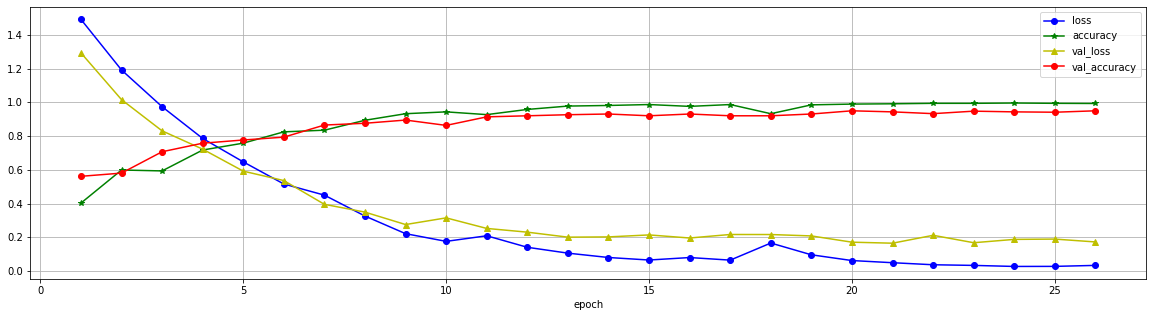

In [ ]:
# Check if trained model already exists, if it does, load the weights, otherwise train and plot the figure

savedModel = parent_dir+'Capstone_NN_weights.h5'

if os.path.isfile(savedModel):
  model.load_weights(savedModel)
else:
  mc = ModelCheckpoint("model-cap.h5", monitor="val_loss", verbose=1, save_best_only=True, save_weights_only=True, mode="min")
  es = EarlyStopping(monitor="val_loss", patience=5, mode="min")
  history = model.fit(train_padded, y_train, 
                    validation_data = (test_padded, y_test), 
                    epochs = 50,
                    batch_size = 100,
                    callbacks = [mc, es])
  
  plt.figure()
  L = len(history.history["loss"]) + 1
  plt.plot(range(1, L), history.history["loss"], "bo-", label = "loss")
  plt.plot(range(1, L), history.history["accuracy"], "g*-", label = "accuracy")
  plt.plot(range(1, L), history.history["val_loss"], "y^-", label = "val_loss")
  plt.plot(range(1, L), history.history["val_accuracy"], "ro-", label = "val_accuracy")
  plt.legend()
  plt.xlabel("epoch")
  plt.grid()
  plt.show()

  model.save(savedModel.replace('_weights', ''))
  model.save_weights(savedModel)

Based on the above run, we can see that we have got **95%+ accuracy** which seems to be **good**.

As we can see from the above executions, both **ML** and **DL** models are performing really **well** and have **good training/validation accuracy**.


Out of the two, we would **prefer ML model** as they are **explainable**, specifically either **SVC**(f1: **0.983**) or **RF**(f1: **0.981**) as those models are performing best among all the models.

# **Model Performance**

Both ML and DL models have performed really well so further optimisation is not required.
The models have **performed well** because of the **Data-preprocessing** and **Upsampling**.

If the model wouldn’t have performed well, we could have done the following:

1. **Hyper-parameter tuning** to identify the **best parameters** to work with for **DL model**.
2. **Data Augumentation** by generating **Synthetic records** via. **synset** nltk.
3. **PCA** for **dimensionality reduction** to see if the dimension reduction helps in better training.
4. Working with different **dropout** combinations.

# **Creating a FLASK APP to predict accident severity**

In [38]:
# This method processes the input and prepares it to be passed to the model for prediction.
def prepareAndProcess(pred_text):
  pred_text = cleanseText(pred_text)
  pred_text = expand(pred_text)
  pred_text = lemma(pred_text)
  pred_token = tokenizer.texts_to_sequences([pred_text])
  pred_padded = pad_sequences(pred_token, maxlen=max_len, padding='post', truncating='post')
  return pred_padded

In [39]:
!pip install flask-ngrok
!pip install flask-bootstrap
!pip install pyngrok

from flask_ngrok import run_with_ngrok
from flask import Flask, render_template , request

     |████████████████████████████████| 456 kB 4.3 MB/s 
  Created wheel for flask-bootstrap: filename=Flask_Bootstrap-3.3.7.1-py3-none-any.whl size=460124 sha256=44491a9afb543632ccb70df72acf0c6232ccf31f05b987f7a02bc6210a7a193f
  Stored in directory: /root/.cache/pip/wheels/67/a2/d6/50d039c9b59b4caca6d7b53839c8100354a52ab7553d2456eb
  Created wheel for visitor: filename=visitor-0.1.3-py3-none-any.whl size=3943 sha256=75680027946c7c2a40eae8bf0727efb9624c1b593e08891038ff632c62c36a15
  Stored in directory: /root/.cache/pip/wheels/64/34/11/053f47218984c9a31a00f911ed98dda036b867481dcc527a12
Successfully built flask-bootstrap visitor
     |████████████████████████████████| 745 kB 4.2 MB/s 
  Created wheel for pyngrok: filename=pyngrok-5.1.0-py3-none-any.whl size=19006 sha256=c59c6d6afdcb3e915f9af70ccb54b6b0ae1a9f3968eedd8bf80476078da33165
  Stored in directory: /root/.cache/pip/wheels/bf/e6/af/ccf6598ecefecd44104069371795cb9b3afbcd16987f6ccfb3
Successfully built pyngrok


In [40]:
# Sign-up to ngrok.com and replace XXXX with your auth token to open a tunnel to the locally deployed app.
!ngrok authtoken XXXX

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [41]:
# This method takes in the input text and processes it to be passed to the model and then predict the outcome using SVC model.
def predict(text):
  pred_padded = prepareAndProcess(text)
  svcModel = pickle.load(open(pickledModel, 'rb'))
  prediction = svcModel.predict(pred_padded)[0]

  if(prediction == 0):
    return 'Predicted Accident Level: I'
  elif(prediction == 1):
    return 'Predicted Accident Level: II'
  elif(prediction == 2):
    return 'Predicted Accident Level: III'
  elif(prediction == 3):
    return 'Predicted Accident Level: IV'
  elif(prediction == 4):
    return 'Predicted Accident Level: V'

In [42]:
# Creating a flask app, loading the template and CSS from the below locations and running the app with ngrok

app = Flask(__name__, template_folder=parent_dir+'templates')
app.static_folder = parent_dir+'static'

run_with_ngrok(app)
@app.route("/")
def home():
    return render_template("index.html")

@app.route("/get")
def get_bot_response():
    userText = request.args.get('msg')
    return predict(userText)

if __name__ == '__main__':
   app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://7612-35-187-156-47.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [08/Jan/2022 16:11:29] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [08/Jan/2022 16:11:30] "GET /static/styles/style.css HTTP/1.1" 200 -
127.0.0.1 - - [08/Jan/2022 16:11:33] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [08/Jan/2022 16:11:36] "GET /get?msg=iuhiuh HTTP/1.1" 200 -
127.0.0.1 - - [08/Jan/2022 16:11:39] "GET /get?msg=hiuiii HTTP/1.1" 200 -
127.0.0.1 - - [08/Jan/2022 16:11:44] "GET /get?msg=jbbjbbbbubibuuibu HTTP/1.1" 200 -


# **Overview of the final process**

- Problem methodology: The given problem is a multi class classification NLP problem where we have to predict the accident level based on the accident description provided.
- After loading and cleaning the data, we used various EDA techniques to get insight into the data and its distribution for various features.
- Since it is an NLP problem we used corresponding techniques to process the data in a meaningful way so that it can be used by ML and DL models.
- For more details on EDA, Data pre-processing, refer above sections - **EDA Approach** and **Pre-processing**

- We used various ML classification models with GridSearchCV for hyper parameter tuning to identify which model works better.
- We also used Bidirectional LSTM model to identify how this behaves compared to the ML models.

# **Step-by-step walk through the solution**

- We imported the necessary libraries and loaded the data.

- We glanced through the data and came up with the initial findings which can be found in the above section - **Findings**.

- We also listed down what each feature column means and how we can use each column. Refer the points listed just above the section - **EDA Approach**.

- Then we started off with univariate, bivariate EDA including visualizations to gain insight from the data and identify hidden patterns. After EDA was done, we concluded on the findings and patterns identified. Refer the section 

- **EDA Summary**.

- Then we started off with data pre-processing like duplicate removal, stop word removal, cleansing, lemmatization, handling target imbalance, glove embedding generation, sequence padding, train-test splitting, target label encoding. Refer above section - **Pre-processing**. 

- Then we started off with model building, since it was a classification problem, we first used ML models in GridSearchCV to identify the best performing ML model. Afterwards, we used LSTM DL model as well to check the model performance. We were getting good performance with both ML and DL models but since ML models are generally explainable we selected SVC model to use for our chatbot application. Refer above section - **Deciding Models and Model Building**.

- After pickling the best performing model, we started off with a Flask web-app creation to deploy the model and predict the accident level.

- We deployed the flask app on ngrok to be able to launch the webapp publicly from google colab.

- The final deployed chatbot application greets the user and asks them for an accident description to be able to predict the accident level.

# **Model evaluation**

- We used multiple ML models with GridSearch CV to identify the best performing one among ML models and LSTM DL model.
- We observed that model performance was almost similar for Support Vector Classifier (SVC), Random Forest (RF), LSTM model. Refer below table which shows the comparison of various ML models.
- We selected SVC for our chatbot because:
    - It is an ML model, hence explainable when compared to DL models.
    - SVC will first generate hyperplanes iteratively that separates the classes in the best way possible.
    - After that it will choose the hyperplane that segregate the classes correctly.

- For SVC, the prominent hyper-parameters are Kernel, Gamma and C, we used GridSearchCV to identify best value for these hyper-parameters to get better model performance. Refer above section - **Deciding Models and Model Building**.

- We did cross validation in GridSearchCV, compared the predictions over test data, used F1-score to evaluate the model performance. After the app was deployed, we used some descriptions from the test data and cross verified that they are predicted properly.

In [43]:
result

,Training Score,Accuracy,Recall,Precision,F1 score
Model,,,,,
LR,0.747,0.715190,0.715,0.696,0.702
SVC,0.991,0.983122,0.983,0.984,0.983
RF,0.986,0.981013,0.981,0.982,0.981
ADA,0.722,0.694093,0.694,0.696,0.694
ExTC,0.987,0.962025,0.962,0.962,0.962
KNN,0.881,0.869198,0.869,0.869,0.852
LGBM,0.987,0.943038,0.943,0.942,0.941
XGB,0.983,0.943038,0.943,0.944,0.941


# **Comparison to benchmark**

- When we initially started off, there was a huge target imbalance which was affecting the model accuracy (as expected). 
- Initially we were using just 2-3 models with less hyper parameters to be tuned which was also playing a role in model performance.
- We started off with 50 words as the max sentence length where we were losing some of the important features in the accident description.

- To address all these, we balanced the data, ran GridSearch on more number of models with more hyper parameter tuning and increased the max sentence length to 200 words with 6B 50D glove embeddings.

# **Visualizations**

- The detailed visualizations and conclusions can be reffered from above sections- **EDA Approach** and **EDA Summary**, respectively.

# **Implications**

- With the EDA we have done for this solution, the companies can address some of the **security risks** based on the EDA findings like which sector/country has most number of accidents, which time of the year the number of accidents are more, why third party employees are more prone to accidents?

- With the chatbot, we can predict the accident severity for a live accident and take appropriate measures based on the severity. If it is a more severe accident, then it has to be addressed quickly to avoid fatalities.

- All the findings, prediction is done based on the historical data provided, so the EDA findings can be taken with great confidence. The accuracy of the model is also very good, however it is also because of upsampling the minority classes so there will be some level of skewness. 


# **Limitations**

- The problem statement says that the accident level could be from I to VI but we don't have a single record for accident level VI. So, if the actual accident level to be predicted is VI, the model will not be able to predict that as we had no data to train the model. Likewise we had less data for accident level V, so there could be some inconsistencies with predicting for accident level V as well.

- Since there was a huge target imbalance we have not got enough variation for minority classes and if an accident description provided is completely different from what the model is trained with, then it won't be able to predict properly.

- If the description is too short or vague, there are a lot of spelling mistakes in the description, then the model won't be able to predict properly.

- Since the model is trained with english corpus, if the description provided is in a different language, the model won't work.

- Since the data has limited number of sectors (Mining, Metals, etc), the model might not predict properly if the description provided is from a completely different sector.

- To enhance the model, we would need a lot more data from target minority classes, more data from difffernt sectors, more data from different countries.

# **Closing Reflections**

- We have learnt industry practices being followed for data science problems during our mentored sessions for this project.

- We have learnt about MLFlow and its uses.

- We have learnt about creating a flask app and use a pickled model to predict and return the prediction back to the user.

- We have learnt about how we can deploy our flask app with ngrok and get a public IP to access the APP.

- If we were to do this again, next time we will create this project as per the industry practices instead of doing it in a PY notebook. We will create a CI-CD pipeline to load, cleanse, process the data, run the model, run unit tests, use Github actions to deploy the model automatically on some server like Horeku


# **Chatbot GUI**

**Following is the working snapshot of the chatbot GUI for accident level prediction**

![picture](https://drive.google.com/file/d/1GQV5J4rs22MDWBTChddId2b0TOHUThKu/view?usp=sharing)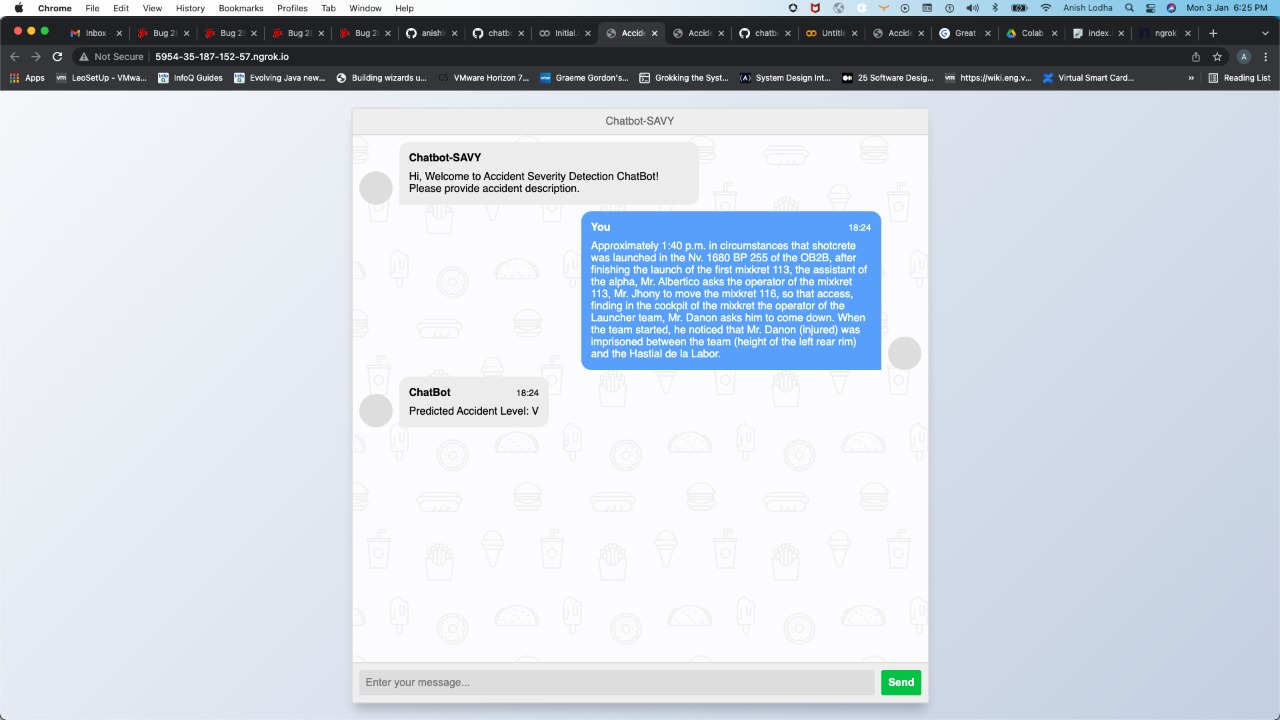

